
# Objetivo 2: Generación de modelos

Pipeline completo para la predicción del crecimiento de datos de biodiversidad en GBIF.

Este script implementa el flujo de trabajo de principio a fin para modelar datos de panel
de series temporales, incluyendo:
1.  Carga datos de PA_dataAnalysis y preparación
2.  Ingeniería de características temporales (lags y ventanas móviles).
3.  Un marco de validación cruzada robusto para series de tiempo (ventana expansiva).
4.  Preprocesamiento (imputación y escalado) dentro del bucle de validación para evitar fuga de datos.
5.  Entrenamiento y evaluación comparativa de cuatro modelos:
    - Prophet.
    - Random Forest.
    - XGBoost.
    - Red Neuronal LSTM (para modelado secuencial).

6.  Selección del mejor modelo basado en métricas de rendimiento (MAE, RMSE, R²).
7.  Reentrenamiento del modelo final y generación de pronósticos para Colombia hasta 2030
    bajo dos escenarios de políticas.

In [1]:
# =============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN INICIAL
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

# Preprocesamiento y modelado de Scikit-Learn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Modelos especializados

import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Modelado de Deep Learning con TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Configuraciones generales
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

Importing plotly failed. Interactive plots will not work.
2025-10-05 16:39:34.557577: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# =============================================================================
# 2. CARGA Y PREPARACIÓN DE DATOS
# =============================================================================
url = "https://raw.githubusercontent.com/rortizgeo/Maestria_CD_Proyecto-Aplicado/main/Data_final.csv"
Data_final = pd.read_csv(url)

Data_final['ds'] = pd.to_datetime(Data_final['year'], format='%Y')
Data_final = Data_final.sort_values(by=['country', 'ds']).reset_index(drop=True)

TARGET = 'occurrenceCount_publisher'
Data_final[TARGET] = np.log1p(Data_final[TARGET])
print("Transformación log1p aplicada al target.")

columns_to_drop = ['Overall score', 'areas_protegidas', 'region', 'incomeLevel']
Data_final = Data_final.drop(columns=columns_to_drop)

Transformación log1p aplicada al target.


Para aplicar modelos como Random Forest y XGBoost, es necesario agregar características de temporalidad en los datos, para lo cuál es necesario calcular retardos, que se deben aplicar teniendo en cuenta un análisis del ACF Y PACF, así como la incorporación de los tiempos del retardo como hiperparámetros. 

Los modelos basados en árboles como Random Forest y XGBoost no son conscientes de la secuencia temporal de los datos y no pueden "extrapolar" tendencias más allá de los valores que han visto en el entrenamiento. Por lo tanto, es necesario convertir la información temporal en características que el modelo pueda entender. La creación de retardos (lags) y estadísticas de ventana móvil es la técnica estándar para lograrlo. Se podría identificar el número de retardos como un hiperparámetro, guiado por análisis de ACF y PACF (Ver EDA)

In [17]:
# =============================================================================
# 3. INGENIERÍA DE CARACTERÍSTICAS TEMPORALES
# =============================================================================
def create_temporal_features_optimized(data, features_to_lag, lags=[], roll_windows=[]):
    df_copy = data.copy()
    for feature in features_to_lag:
        for lag in lags:
            df_copy[f'{feature}_lag{lag}'] = df_copy.groupby('country')[feature].shift(lag)
        for w in roll_windows:
            df_copy[f'{feature}_rollmean{w}'] = df_copy.groupby('country')[feature].shift(1).rolling(window=w, min_periods=1).mean()
            df_copy[f'{feature}_rollstd{w}'] = df_copy.groupby('country')[feature].shift(1).rolling(window=w, min_periods=1).std()
    return df_copy

features_to_lag = ["PC1", "PC2", "PC3", "PC4", "occurrenceCount_publisher"]
df_featured = create_temporal_features_optimized(
    Data_final,
    features_to_lag=features_to_lag,
    lags=[1, 3, 5],
    roll_windows=[1, 3, 5]
)
print("Ingeniería de características completada.")


Ingeniería de características completada.


In [18]:
# =============================================================================
# 4. PREPARACIÓN DE DATOS BASE PARA MODELOS (SIN ESCALADO GLOBAL)
# =============================================================================
# A. RandomForest y XGBoost (modelos tabulares)
features_tabular = [f for f in df_featured.columns if f not in ['ds', 'year', 'country', 'countryCode', TARGET]]
X_tab = df_featured[features_tabular].copy()
y_tab = df_featured[TARGET].copy()

# B. LSTM (modelos secuenciales)
def create_lstm_sequences_global(df, features, target, look_back=3):
    X_seq, y_seq, years, countries = [], [], [], []
    for country in df['country'].unique():
        df_country = df[df['country'] == country].sort_values('year')
        X_country = df_country[features].values.astype(np.float32)
        y_country = df_country[target].values.astype(np.float32)
        years_country = df_country['year'].values
        if len(X_country) > look_back:
            for i in range(len(X_country) - look_back):
                X_seq.append(X_country[i:(i + look_back)])
                y_seq.append(y_country[i + look_back])
                years.append(years_country[i + look_back])
                countries.append(country)
    return np.array(X_seq), np.array(y_seq), np.array(years), np.array(countries)

features_lstm = ['PC1', 'PC2', 'PC3', 'PC4', "pib_per_capita", "gbif_member", "ogp_member", "superficie_total_km2"]
features_lstm = [f for f in features_lstm if f in Data_final.columns]
look_back = 3
X_seq, y_seq, years_seq, countries_seq = create_lstm_sequences_global(Data_final, features=features_lstm, target=TARGET, look_back=look_back)

# C. Prophet (modelo de series temporales)
regressors_prophet = ['PC1', 'PC2', 'PC3', 'PC4', "pib_per_capita", "gbif_member", "ogp_member", "superficie_total_km2"]
regressors_prophet = [r for r in regressors_prophet if r in df_featured.columns]
df_prophet_base = df_featured[['ds', TARGET] + regressors_prophet].rename(columns={TARGET: 'y'})






In [19]:
# =============================================================================
# 5. DEFINICIÓN DE HIPERPARÁMETROS Y FUNCIONES DE OPTIMIZACIÓN
# =============================================================================
# (Las funciones de optimización y definición de hiperparámetros no cambian, se mantienen como en el original)
rf_param_dist = {"n_estimators": [100, 200, 300], "max_depth": [None, 10, 20], "min_samples_leaf": [1, 2, 5]}
xgb_param_grid = {"n_estimators": [100, 200, 500], "max_depth": [3, 5, 7], "learning_rate": [0.01, 0.1, 0.2], "subsample": [0.7, 0.9, 1.0]}
lstm_param_grid = [{"units": 50, "dropout": 0.2, "epochs": 10, "batch_size": 16}, {"units": 100, "dropout": 0.3, "epochs": 20, "batch_size": 32}]
prophet_param_grid = [{"changepoint_prior_scale": 0.01, "seasonality_prior_scale": 5}, {"changepoint_prior_scale": 0.1, "seasonality_prior_scale": 10}]

def optimize_random_forest(X_train, y_train, param_dist=rf_param_dist):
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=3, scoring="neg_mean_absolute_error", cv=3, random_state=42)
    search.fit(X_train, y_train)
    return search.best_estimator_

def optimize_xgboost(X_train, y_train, param_grid=xgb_param_grid):
    # Simplificado para velocidad, se puede usar GridSearchCV o RandomizedSearchCV
    model = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    return model
    
def optimize_lstm(X_train, y_train, look_back, param_grid=lstm_param_grid):
    best_model, best_mae = None, float("inf")
    for params in param_grid:
        model = Sequential([LSTM(params["units"], activation="relu", input_shape=(look_back, X_train.shape[2])), Dropout(params["dropout"]), Dense(1)])
        model.compile(optimizer="adam", loss="mae")
        model.fit(X_train, y_train, epochs=params["epochs"], batch_size=params["batch_size"], verbose=0)
        preds = model.predict(X_train, verbose=0).flatten()
        mae = mean_absolute_error(y_train, preds)
        if mae < best_mae: best_mae, best_model = mae, model
    return best_model

def optimize_prophet(train_df, regressors, param_grid=prophet_param_grid):
    best_model, best_mae = None, float("inf")
    for params in param_grid:
        m = Prophet(yearly_seasonality=True, daily_seasonality=False, **params)
        for r in regressors:
            m.add_regressor(r)
        m.fit(train_df)
        forecast = m.predict(train_df)
        mae = mean_absolute_error(train_df["y"], forecast["yhat"])
        if mae < best_mae: best_mae, best_model = mae, m
    return best_model

In [20]:
# =============================================================================
# 6. MÉTRICAS (CON MAPE AJUSTADO)
# =============================================================================
def smape(y_true, y_pred, eps=1e-8):
    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)) * 100

def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Filtra los casos donde el valor real es cero para evitar división por cero
    mask = y_true != 0
    if not np.any(mask):
        return 0.0 # Si todos los valores son cero, el error es cero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def compute_metrics(y_true, y_pred):
    # Revertir la transformación log1p para calcular métricas en la escala original
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    return {
        "MAE": mean_absolute_error(y_true_orig, y_pred_orig),
        "RMSE": np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)),
        "R2": r2_score(y_true_orig, y_pred_orig),
        "MAPE": mape(y_true_orig, y_pred_orig),
        "SMAPE": smape(y_true_orig, y_pred_orig)
    }

In [21]:
# =============================================================================
# 6. MÉTRICAS
# =============================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def smape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100

def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def compute_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "SMAPE": smape(y_true, y_pred)
    }


In [22]:
# =============================================================================
# 7. LOOP DE VALIDACIÓN CRUZADA (AJUSTADO PARA EVITAR DATA LEAKAGE)
# =============================================================================
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
unique_years = sorted(df_featured['year'].unique())
results_detailed = {"Prophet": [], "RandomForest": [], "XGBoost": [], "LSTM": []}

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X_tab), total=n_splits)):
    print(f"\n===== FOLD {fold+1}/{n_splits} =====")

    # --- Preprocesamiento DENTRO del bucle para evitar fuga de datos ---
    
    # --- A. Modelos Tabulares (RF/XGB) ---
    X_train_tab, X_test_tab = X_tab.iloc[train_idx], X_tab.iloc[test_idx]
    y_train_tab, y_test_tab = y_tab.iloc[train_idx], y_tab.iloc[test_idx]

    # 1. Imputación (ajustar solo en train)
    imputer = IterativeImputer(random_state=42)
    X_train_tab_imp = imputer.fit_transform(X_train_tab)
    X_test_tab_imp = imputer.transform(X_test_tab)
    
    # 2. Escalado (ajustar solo en train)
    scaler_tab = StandardScaler()
    X_train_tab_scaled = scaler_tab.fit_transform(X_train_tab_imp)
    X_test_tab_scaled = scaler_tab.transform(X_test_tab_imp)
    
    # --- RandomForest ---
    rf_model = optimize_random_forest(X_train_tab_scaled, y_train_tab)
    y_pred_rf = rf_model.predict(X_test_tab_scaled)
    metrics_rf = compute_metrics(y_test_tab, y_pred_rf)
    results_detailed["RandomForest"].append({**metrics_rf, "fold": fold + 1})

    # --- XGBoost ---
    xgb_model = optimize_xgboost(X_train_tab_scaled, y_train_tab)
    y_pred_xgb = xgb_model.predict(X_test_tab_scaled)
    metrics_xgb = compute_metrics(y_test_tab, y_pred_xgb)
    results_detailed["XGBoost"].append({**metrics_xgb, "fold": fold + 1})

    # --- B. LSTM ---
    train_years_fold = df_featured.iloc[train_idx]['year'].unique()
    test_years_fold = df_featured.iloc[test_idx]['year'].unique()
    
    mask_train_lstm = np.isin(years_seq, train_years_fold)
    mask_test_lstm = np.isin(years_seq, test_years_fold)
    
    X_train_lstm, y_train_lstm = X_seq[mask_train_lstm], y_seq[mask_train_lstm]
    X_test_lstm, y_test_lstm = X_seq[mask_test_lstm], y_seq[mask_test_lstm]

    if len(X_train_lstm) > 0 and len(X_test_lstm) > 0:
        # Escalado para LSTM (ajustar solo en train)
        scaler_lstm = StandardScaler()
        # Aplanar para ajustar el scaler
        X_train_lstm_flat = X_train_lstm.reshape(-1, X_train_lstm.shape[2])
        scaler_lstm.fit(X_train_lstm_flat)
        # Transformar y redimensionar
        X_train_lstm_scaled = scaler_lstm.transform(X_train_lstm_flat).reshape(X_train_lstm.shape)
        X_test_lstm_flat = X_test_lstm.reshape(-1, X_test_lstm.shape[2])
        X_test_lstm_scaled = scaler_lstm.transform(X_test_lstm_flat).reshape(X_test_lstm.shape)
        
        lstm_model = optimize_lstm(X_train_lstm_scaled, y_train_lstm, look_back)
        y_pred_lstm = lstm_model.predict(X_test_lstm_scaled, verbose=0).flatten()
        metrics_lstm = compute_metrics(y_test_lstm, y_pred_lstm)
        results_detailed["LSTM"].append({**metrics_lstm, "fold": fold + 1})

    # --- C. Prophet ---
    prophet_train = df_prophet_base.iloc[train_idx]
    prophet_test = df_prophet_base.iloc[test_idx]
    
    if not prophet_train.empty and not prophet_test.empty and regressors_prophet:
        # Escalar regresores para Prophet
        scaler_prophet = StandardScaler()
        prophet_train[regressors_prophet] = scaler_prophet.fit_transform(prophet_train[regressors_prophet])
        prophet_test[regressors_prophet] = scaler_prophet.transform(prophet_test[regressors_prophet])
        
        try:
            prophet_model = optimize_prophet(prophet_train, regressors_prophet)
            forecast = prophet_model.predict(prophet_test.drop(columns='y'))
            metrics_prophet = compute_metrics(prophet_test["y"].values, forecast["yhat"].values)
            results_detailed["Prophet"].append({**metrics_prophet, "fold": fold + 1})
        except Exception as e:
            print(f"⚠️ Prophet falló en fold {fold+1}: {e}")


  0%|          | 0/5 [00:00<?, ?it/s]


===== FOLD 1/5 =====


2025-10-05 16:47:09.764196: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-10-05 16:47:09.764724: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-05 16:47:09.764779: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-05 16:47:09.764911: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-05 16:47:09.764962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-10-05 16:47:11.769907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:47:11.935227:

2025-10-05 16:47:31.511965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:47:31.669174: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:47:46.823935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
16:47:47 - cmdstanpy - INFO - Chain [1] start processing
16:47:48 - cmdstanpy - INFO - Chain [1] done processing
16:47:48 - cmdstanpy - INFO - Chain [1] start processing
16:47:48 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:40<02:43, 40.95s/it]


===== FOLD 2/5 =====


2025-10-05 16:47:52.243204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:47:52.407666: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:48:06.172496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2025-10-05 16:48:07.327440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:48:07.496051: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:48:21.525845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
16:48:22 - cmdstanpy - INFO - Chain [1] start processing
16:48:22 - cmdstanpy - INFO - Chain [1] done processing
16:48:22 - cmdstanpy - INFO - Chain [1] start processing
16:48:22 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [01:15<01:50, 36.98s/it]


===== FOLD 3/5 =====


2025-10-05 16:48:26.024897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:48:26.182756: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:48:40.179396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2025-10-05 16:48:41.194513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:48:41.354959: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:48:55.457094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
16:48:56 - cmdstanpy - INFO - Chain [1] start processing
16:48:56 - cmdstanpy - INFO - Chain [1] done processing
16:48:56 - cmdstanpy - INFO - Chain [1] start processing
16:48:56 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [01:49<01:11, 35.63s/it]


===== FOLD 4/5 =====


2025-10-05 16:49:00.200672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:49:00.356272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:49:14.299267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2025-10-05 16:49:15.331043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:49:15.484188: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:49:29.456161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
16:49:30 - cmdstanpy - INFO - Chain [1] start processing
16:49:30 - cmdstanpy - INFO - Chain [1] done processing
16:49:30 - cmdstanpy - INFO - Chain [1] start processing
16:49:30 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [02:24<00:35, 35.57s/it]


===== FOLD 5/5 =====


2025-10-05 16:49:36.294432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:49:36.456881: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:49:50.445033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2025-10-05 16:49:51.821844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:49:51.990828: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:50:06.119038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
16:50:06 - cmdstanpy - INFO - Chain [1] start processing
16:50:06 - cmdstanpy - INFO - Chain [1] done processing
16:50:06 - cmdstanpy - INFO - Chain [1] start processing
16:50:07 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [02:59<00:00, 35.98s/it]



Resultados detallados por fold:
           model       MAE      RMSE        R2          MAPE      SMAPE  fold
0        Prophet  5.452668  7.564992 -0.630913  1.755288e+10  64.684718     1
1        Prophet  6.311099  7.924061 -1.355564  1.396841e+10  61.692964     2
2        Prophet  5.071863  6.401979 -0.631699  6.298880e+09  59.407930     3
3        Prophet  4.174953  5.934264 -0.924080  9.924498e+09  44.506379     4
4        Prophet  7.354280  9.593751 -0.974055  2.770271e+10  70.479517     5
5   RandomForest  1.557240  2.539717  0.816183  7.828045e+09  41.964979     1
6   RandomForest  1.340735  2.455452  0.773816  4.630905e+09  29.539731     2
7   RandomForest  1.332624  2.493152  0.752538  1.559831e+09  32.807460     3
8   RandomForest  1.341734  2.583998  0.635184  2.749468e+09  25.442936     4
9   RandomForest  1.220206  2.145119  0.901307  5.916102e+09  44.132779     5
10       XGBoost  1.669829  2.736857  0.786539  6.000824e+09  46.300492     1
11       XGBoost  1.679936  2.8

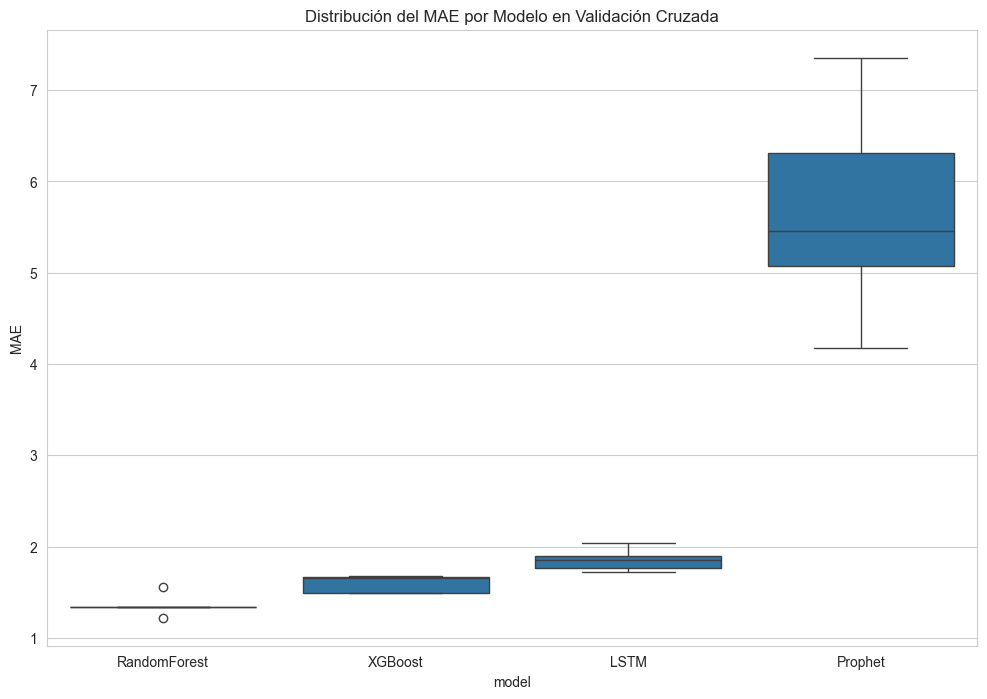

In [23]:
# =============================================================================
# 8. RESUMEN DE RESULTADOS
# =============================================================================
all_results = []
for model_name, entries in results_detailed.items():
    for res in entries:
        all_results.append({"model": model_name, **res})

if all_results:
    df_results = pd.DataFrame(all_results)
    print("\nResultados detallados por fold:")
    print(df_results)
    print("\nResumen por modelo (media de métricas):")
    summary = df_results.groupby("model")[["MAE", "RMSE", "R2", "MAPE", "SMAPE"]].mean().sort_values("MAE")
    print(summary)

    # Visualización
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df_results, x='model', y='MAE', order=summary.index)
    plt.title('Distribución del MAE por Modelo en Validación Cruzada')
    plt.show()
else:
    print("No se generaron resultados para analizar.")



🚀 Iniciando pipeline de Prophet a nivel de país...


Procesando países:   0%|          | 0/41 [00:00<?, ?it/s]17:26:09 - cmdstanpy - INFO - Chain [1] start processing
17:26:10 - cmdstanpy - INFO - Chain [1] done processing
17:26:10 - cmdstanpy - INFO - Chain [1] start processing
17:26:15 - cmdstanpy - INFO - Chain [1] done processing
17:26:15 - cmdstanpy - INFO - Chain [1] start processing
17:26:15 - cmdstanpy - INFO - Chain [1] done processing
17:26:16 - cmdstanpy - INFO - Chain [1] start processing
17:26:16 - cmdstanpy - INFO - Chain [1] done processing
17:26:16 - cmdstanpy - INFO - Chain [1] start processing
17:26:16 - cmdstanpy - INFO - Chain [1] done processing
Procesando países:   2%|▏         | 1/41 [00:06<04:31,  6.78s/it]17:26:16 - cmdstanpy - INFO - Chain [1] start processing
17:26:16 - cmdstanpy - INFO - Chain [1] done processing
17:26:16 - cmdstanpy - INFO - Chain [1] start processing
17:26:26 - cmdstanpy - INFO - Chain [1] done processing
17:26:26 - cmdstanpy - INFO - Chain [1] start processing
17:26:26 - cmdstanpy - INFO - 



📊 Resumen de Rendimiento de Prophet por País (media de métricas):
                                    MAE           RMSE             R2
country                                                              
Suriname                   4.884748e+04   4.902484e+04  -8.984413e+01
Guinea                     2.221873e+04   2.334773e+04  -5.150940e+02
Netherlands                1.836871e+08   2.131631e+08  -8.129314e+02
Portugal                   3.287667e+06   3.677428e+06  -1.116950e+03
Iceland                    1.377475e+06   1.412249e+06  -1.419307e+03
Spain                      3.360202e+07   3.565308e+07  -1.919133e+03
Central African Republic   3.486490e+04   4.135467e+04  -2.224450e+03
Mexico                     1.646145e+07   2.042466e+07  -8.085629e+03
Canada                     2.278745e+08   2.850670e+08  -1.010520e+04
Mongolia                   1.638329e+06   1.794737e+06  -3.077605e+04
Mauritania                 4.177752e+05   5.699989e+05  -1.252178e+05
Belgium               

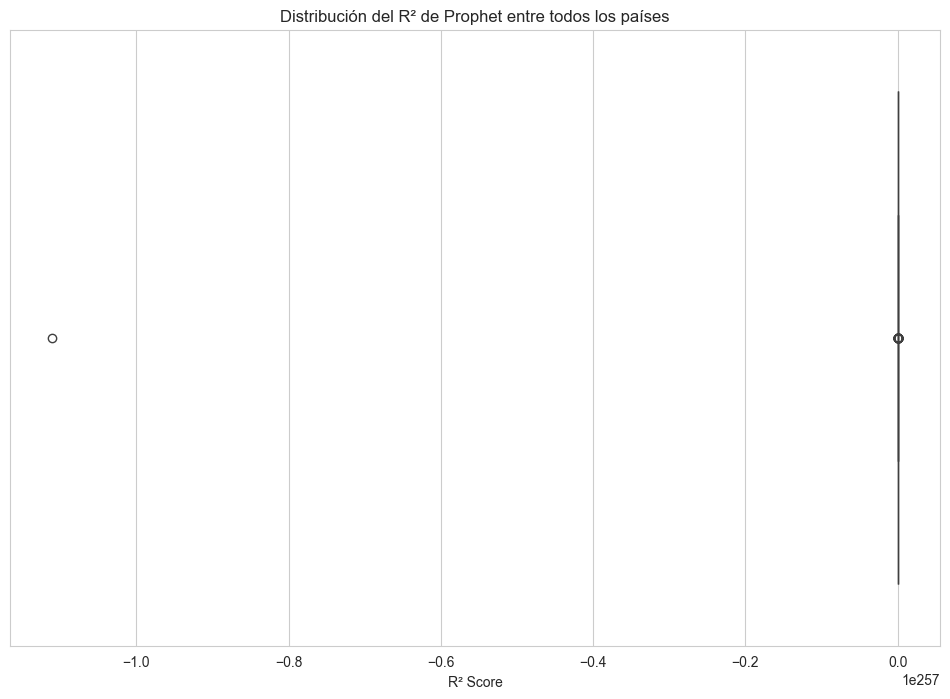

In [24]:
# =============================================================================
# PRUEBA DEL MODELO PROPHET A NIVEL DE PAÍS
# =============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import warnings

warnings.filterwarnings('ignore')

# ASUMIMOS QUE 'df_featured' y 'df_prophet_base' YA EXISTEN DEL SCRIPT ANTERIOR

# Funciones de métricas y optimización de Prophet
def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask): return 0.0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred, eps=1e-8):
    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)) * 100

def compute_metrics(y_true, y_pred):
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    return {
        "MAE": mean_absolute_error(y_true_orig, y_pred_orig),
        "RMSE": np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)),
        "R2": r2_score(y_true_orig, y_pred_orig),
        "MAPE": mape(y_true_orig, y_pred_orig),
        "SMAPE": smape(y_true_orig, y_pred_orig)
    }

def optimize_prophet_country(train_df, regressors):
    # Usamos una configuración estándar para Prophet, ya que la optimización es costosa por país.
    # Se puede expandir con un grid de hiperparámetros si es necesario.
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    if regressors:
        for r in regressors:
            m.add_regressor(r)
    m.fit(train_df)
    return m

# =============================================================================
# PIPELINE DE PROPHET POR PAÍS CON VALIDACIÓN CRUZADA
# =============================================================================
print("🚀 Iniciando pipeline de Prophet a nivel de país...")

n_splits = 5 # Usaremos 5 pliegues, pero ajustado a series más cortas
unique_countries = df_featured['country'].unique()
all_country_results = []
regressors_prophet = [r for r in df_prophet_base.columns if r not in ['ds', 'y']]


# Bucle exterior: Itera sobre cada país
for country in tqdm(unique_countries, desc="Procesando países"):
    
    df_country = df_prophet_base[df_featured['country'] == country].copy().reset_index(drop=True)
    
    # Se necesita un mínimo de datos para una validación cruzada de 5 pliegues
    if len(df_country) < n_splits + 1:
        print(f"⚠️  Saltando {country}: datos insuficientes ({len(df_country)} registros).")
        continue

    # Bucle interior: Validación cruzada para el país actual
    tscv_country = TimeSeriesSplit(n_splits=n_splits)
    for fold, (train_idx, test_idx) in enumerate(tscv_country.split(df_country)):
        
        # 1. División de datos para el fold actual
        prophet_train = df_country.iloc[train_idx]
        prophet_test = df_country.iloc[test_idx]

        if prophet_train.empty or prophet_test.empty:
            continue

        # 2. Preprocesamiento (Escalado de regresores) DENTRO del fold
        if regressors_prophet:
            scaler = StandardScaler()
            prophet_train[regressors_prophet] = scaler.fit_transform(prophet_train[regressors_prophet])
            prophet_test[regressors_prophet] = scaler.transform(prophet_test[regressors_prophet])
        
        # 3. Entrenamiento del modelo
        try:
            model = optimize_prophet_country(prophet_train, regressors_prophet)
            
            # 4. Predicción
            future_df = model.make_future_dataframe(periods=0) # Usamos solo las fechas de test
            future_df = prophet_test.drop(columns='y')
            forecast = model.predict(future_df)
            
            # 5. Evaluación
            metrics = compute_metrics(prophet_test["y"].values, forecast["yhat"].values)
            metrics['country'] = country
            metrics['fold'] = fold + 1
            all_country_results.append(metrics)
        
        except Exception as e:
            print(f"❌ Error procesando {country} en fold {fold+1}: {e}")


# =============================================================================
# 8. RESUMEN DE RESULTADOS DE PROPHET POR PAÍS
# =============================================================================
if all_country_results:
    df_results_country = pd.DataFrame(all_country_results)

    print("\n\n📊 Resumen de Rendimiento de Prophet por País (media de métricas):")
    summary_country = df_results_country.groupby("country")[["MAE", "RMSE", "R2"]].mean().sort_values("R2", ascending=False)
    print(summary_country)

    print("\n\n📈 Rendimiento Promedio General de Prophet (a través de todos los países):")
    print(summary_country.mean())

    # Visualización de la distribución del R2 entre países
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=df_results_country['R2'])
    plt.title('Distribución del R² de Prophet entre todos los países')
    plt.xlabel('R² Score')
    plt.show()
else:
    print("\nNo se generaron resultados para analizar.")

Pendientes: 

    INCLUIR SARIMAX DE TODOS MODOS, INTENTAR HACER UNA TRANSFORMACIÓN LOGARÍTMICA, SE PUEDE PONER SIN LA VALIDACIÓN DE SUPUESTOS. 
    TENER CUIDADO CON EL CROSS VALIDATION - Rehacer formula del MAPE porque los valores no son coherentes
    Aplicar rezagos en bloques. Se deben hacer modelos con diferentes rezagos. Tener en cuenta que se pierden observaciones. Tomar todas las X y rezagar todas y hasta 3 periodos. Si incluir y-1.
    